# Load model

In [1]:
from birdclassification.preprocessing.filtering import filter_recordings_30
from torch.utils.data import DataLoader
import torch
from sklearn.model_selection import train_test_split
from birdclassification.training.dataset import Recordings30
from birdclassification.training.cnn_training_torch.CNN_model import CNNNetwork
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

/home/piotr/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PATH = '../saved_models/model_20231207_212639_2'
cnn = CNNNetwork()
cnn.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [3]:
cnn.eval()

CNNNetwork(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=10880, out_features=30, bias=True)
)

# Prepare dataset

In [4]:
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 123
RECORDINGS_DIR = '/mnt/d/recordings_30/'
# RECORDINGS_DIR =  '/media/jacek/E753-A120/recordings_30/'
NOISES_DIR = '/path/to/noise/dataset'
SAMPLE_RATE = 32000
NUM_SAMPLES = SAMPLE_RATE * 1
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
EPOCHS = 5
NUM_WORKERS = 8

cnn.to(DEVICE)

CNNNetwork(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=10880, out_features=30, bias=True)
)

In [5]:
df = filter_recordings_30("../../../data/xeno_canto_recordings.csv", "../../../data/bird-list-extended.csv", )

train_df, test_val_df = train_test_split(df, stratify=df['Latin name'], test_size=0.2, random_state = SEED)
val_df, test_df = train_test_split(test_val_df, stratify=test_val_df['Latin name'], test_size=0.5, random_state = SEED)

train_ds = Recordings30(train_df, recording_dir=RECORDINGS_DIR, noises_dir=NOISES_DIR, sample_rate=SAMPLE_RATE, device = DEVICE)
val_ds = Recordings30(val_df, recording_dir=RECORDINGS_DIR, noises_dir=NOISES_DIR, sample_rate = 32000, device = DEVICE)
test_ds = Recordings30(test_df, recording_dir=RECORDINGS_DIR, noises_dir=NOISES_DIR,sample_rate = 32000,device = DEVICE)

train_dl  = DataLoader(train_ds, batch_size= BATCH_SIZE, num_workers=NUM_WORKERS)
val_dl  = DataLoader(val_ds, batch_size= BATCH_SIZE, num_workers=NUM_WORKERS)
test_dl  = DataLoader(test_ds, batch_size= BATCH_SIZE, num_workers=NUM_WORKERS)

/home/piotr/thesis/Bird-classification-model/birdclassification/preprocessing/filtering.py:72: DtypeWarning: Columns (10,39,43,44,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  recordings = pd.read_csv(filepath_recordings)


## Show spectrograms

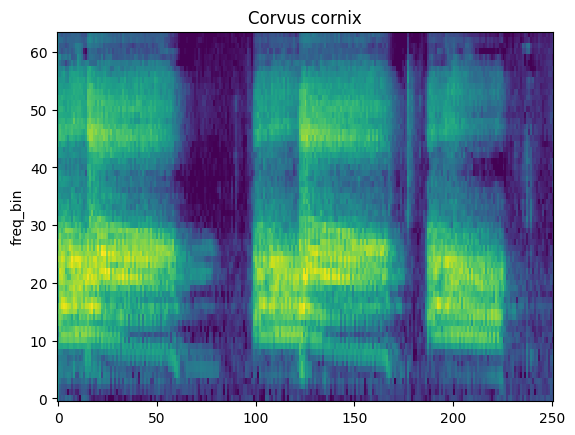

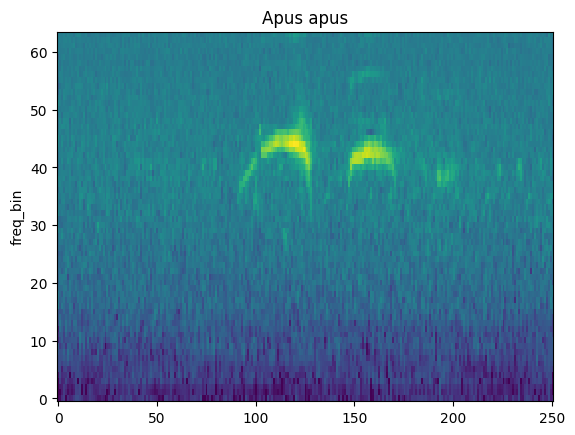

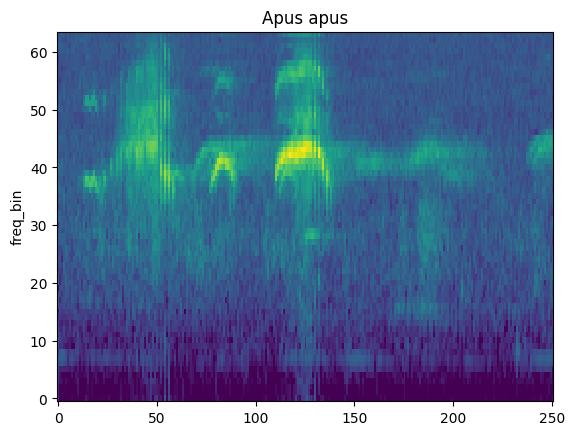

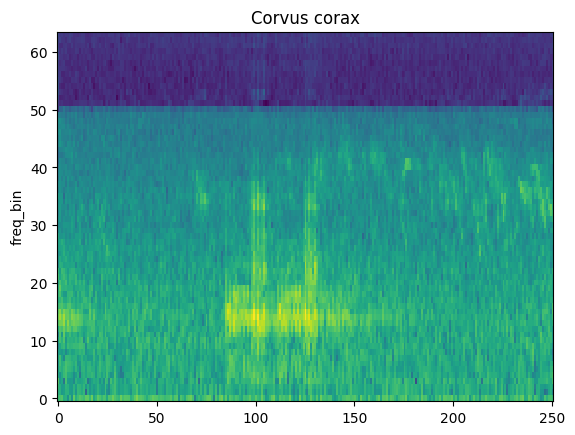

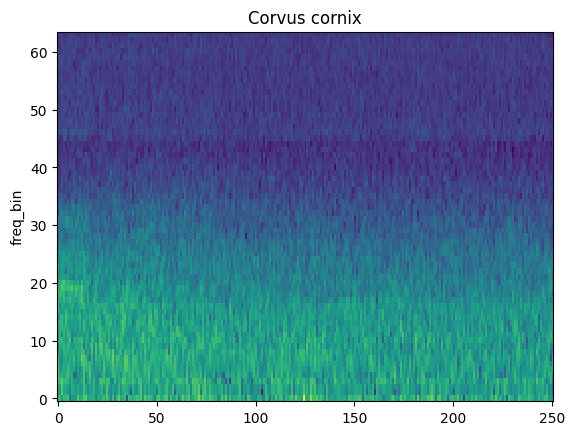

In [6]:
from birdclassification.preprocessing.spectrogram import generate_mel_spectrogram_seq
from birdclassification.visualization.plots import plot_torch_spectrogram

number_of_rec = 5
for i in range(number_of_rec):
    input, label = train_ds[i]
    spectrogram = generate_mel_spectrogram_seq(y=input.to(DEVICE), sr=32000, n_fft=512, hop_length=384, device=DEVICE)
    plot_torch_spectrogram(spectrogram.squeeze(0).cpu(), title=train_ds.get_mapping()[label])

## Predict bird demo

Prediction:  Turdus viscivorus


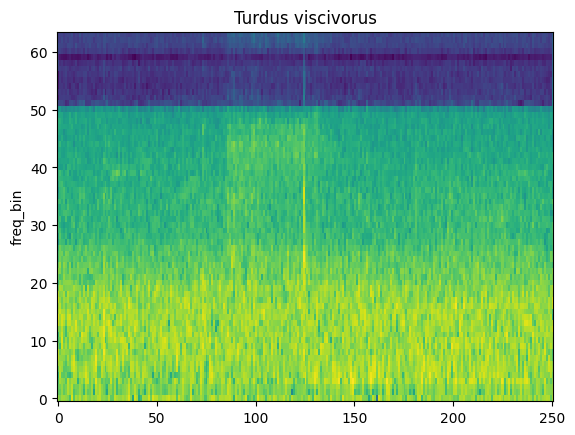

In [7]:
length_in_seconds = 3
sr = 32000
index = 27
map = train_ds.get_mapping()

cnn.eval()
with torch.no_grad():
    input, label = train_ds[index]
    spectrogram = generate_mel_spectrogram_seq(y=input.to(DEVICE), sr=sr, n_fft=512, hop_length=384, device=DEVICE)
    plot_torch_spectrogram(spectrogram.squeeze(0).cpu(), title=map[label])
    spectrogram = torch.unsqueeze(spectrogram, dim=1)
    validation_output = cnn(spectrogram)
    predictions = torch.max(validation_output, dim=1)[1].data.squeeze()
    
print("Prediction: ", train_ds.get_mapping()[predictions.item()])

# Validation

In [8]:
from birdclassification.training.validation_metrics import calculate_metric, get_true_and_predicted_labels
from sklearn.metrics import f1_score, precision_score
import numpy as np

In [19]:
x, y = get_true_and_predicted_labels(cnn, test_dl, DEVICE)

### F1 score (macro averaged)

In [20]:
f1_s = f1_score(x, y, average='macro')
f1_s

0.580312165865465

### Precision (macro averaged)

In [21]:
precision = precision_score(x, y, average='macro')
precision

0.6697529114028317

### Classification report

In [22]:
names = list(train_ds.get_mapping().values())

In [23]:
classification = classification_report(x, y, target_names=names)

In [24]:
print(0, classification)

0                        precision    recall  f1-score   support

      Alauda arvensis       0.59      0.85      0.70       265
   Anas platyrhynchos       0.87      0.51      0.64       108
            Apus apus       0.85      0.73      0.79        71
            Asio otus       0.63      0.59      0.61       126
          Buteo buteo       0.44      0.51      0.47        94
  Carduelis carduelis       0.62      0.71      0.66       207
      Ciconia ciconia       0.57      0.62      0.59        13
        Columba livia       0.44      0.32      0.37        22
         Corvus corax       0.58      0.76      0.66       208
        Corvus cornix       0.67      0.72      0.70       121
    Corvus frugilegus       0.73      0.62      0.67        71
      Cuculus canorus       0.66      0.87      0.75       194
          Cygnus olor       0.63      0.33      0.43        52
    Dendrocopos major       0.76      0.46      0.58       245
  Garrulus glandarius       0.44      0.63      0.52

In [25]:
c_matrix = confusion_matrix(x, y)

Text(470.72222222222223, 0.5, 'Prediction')

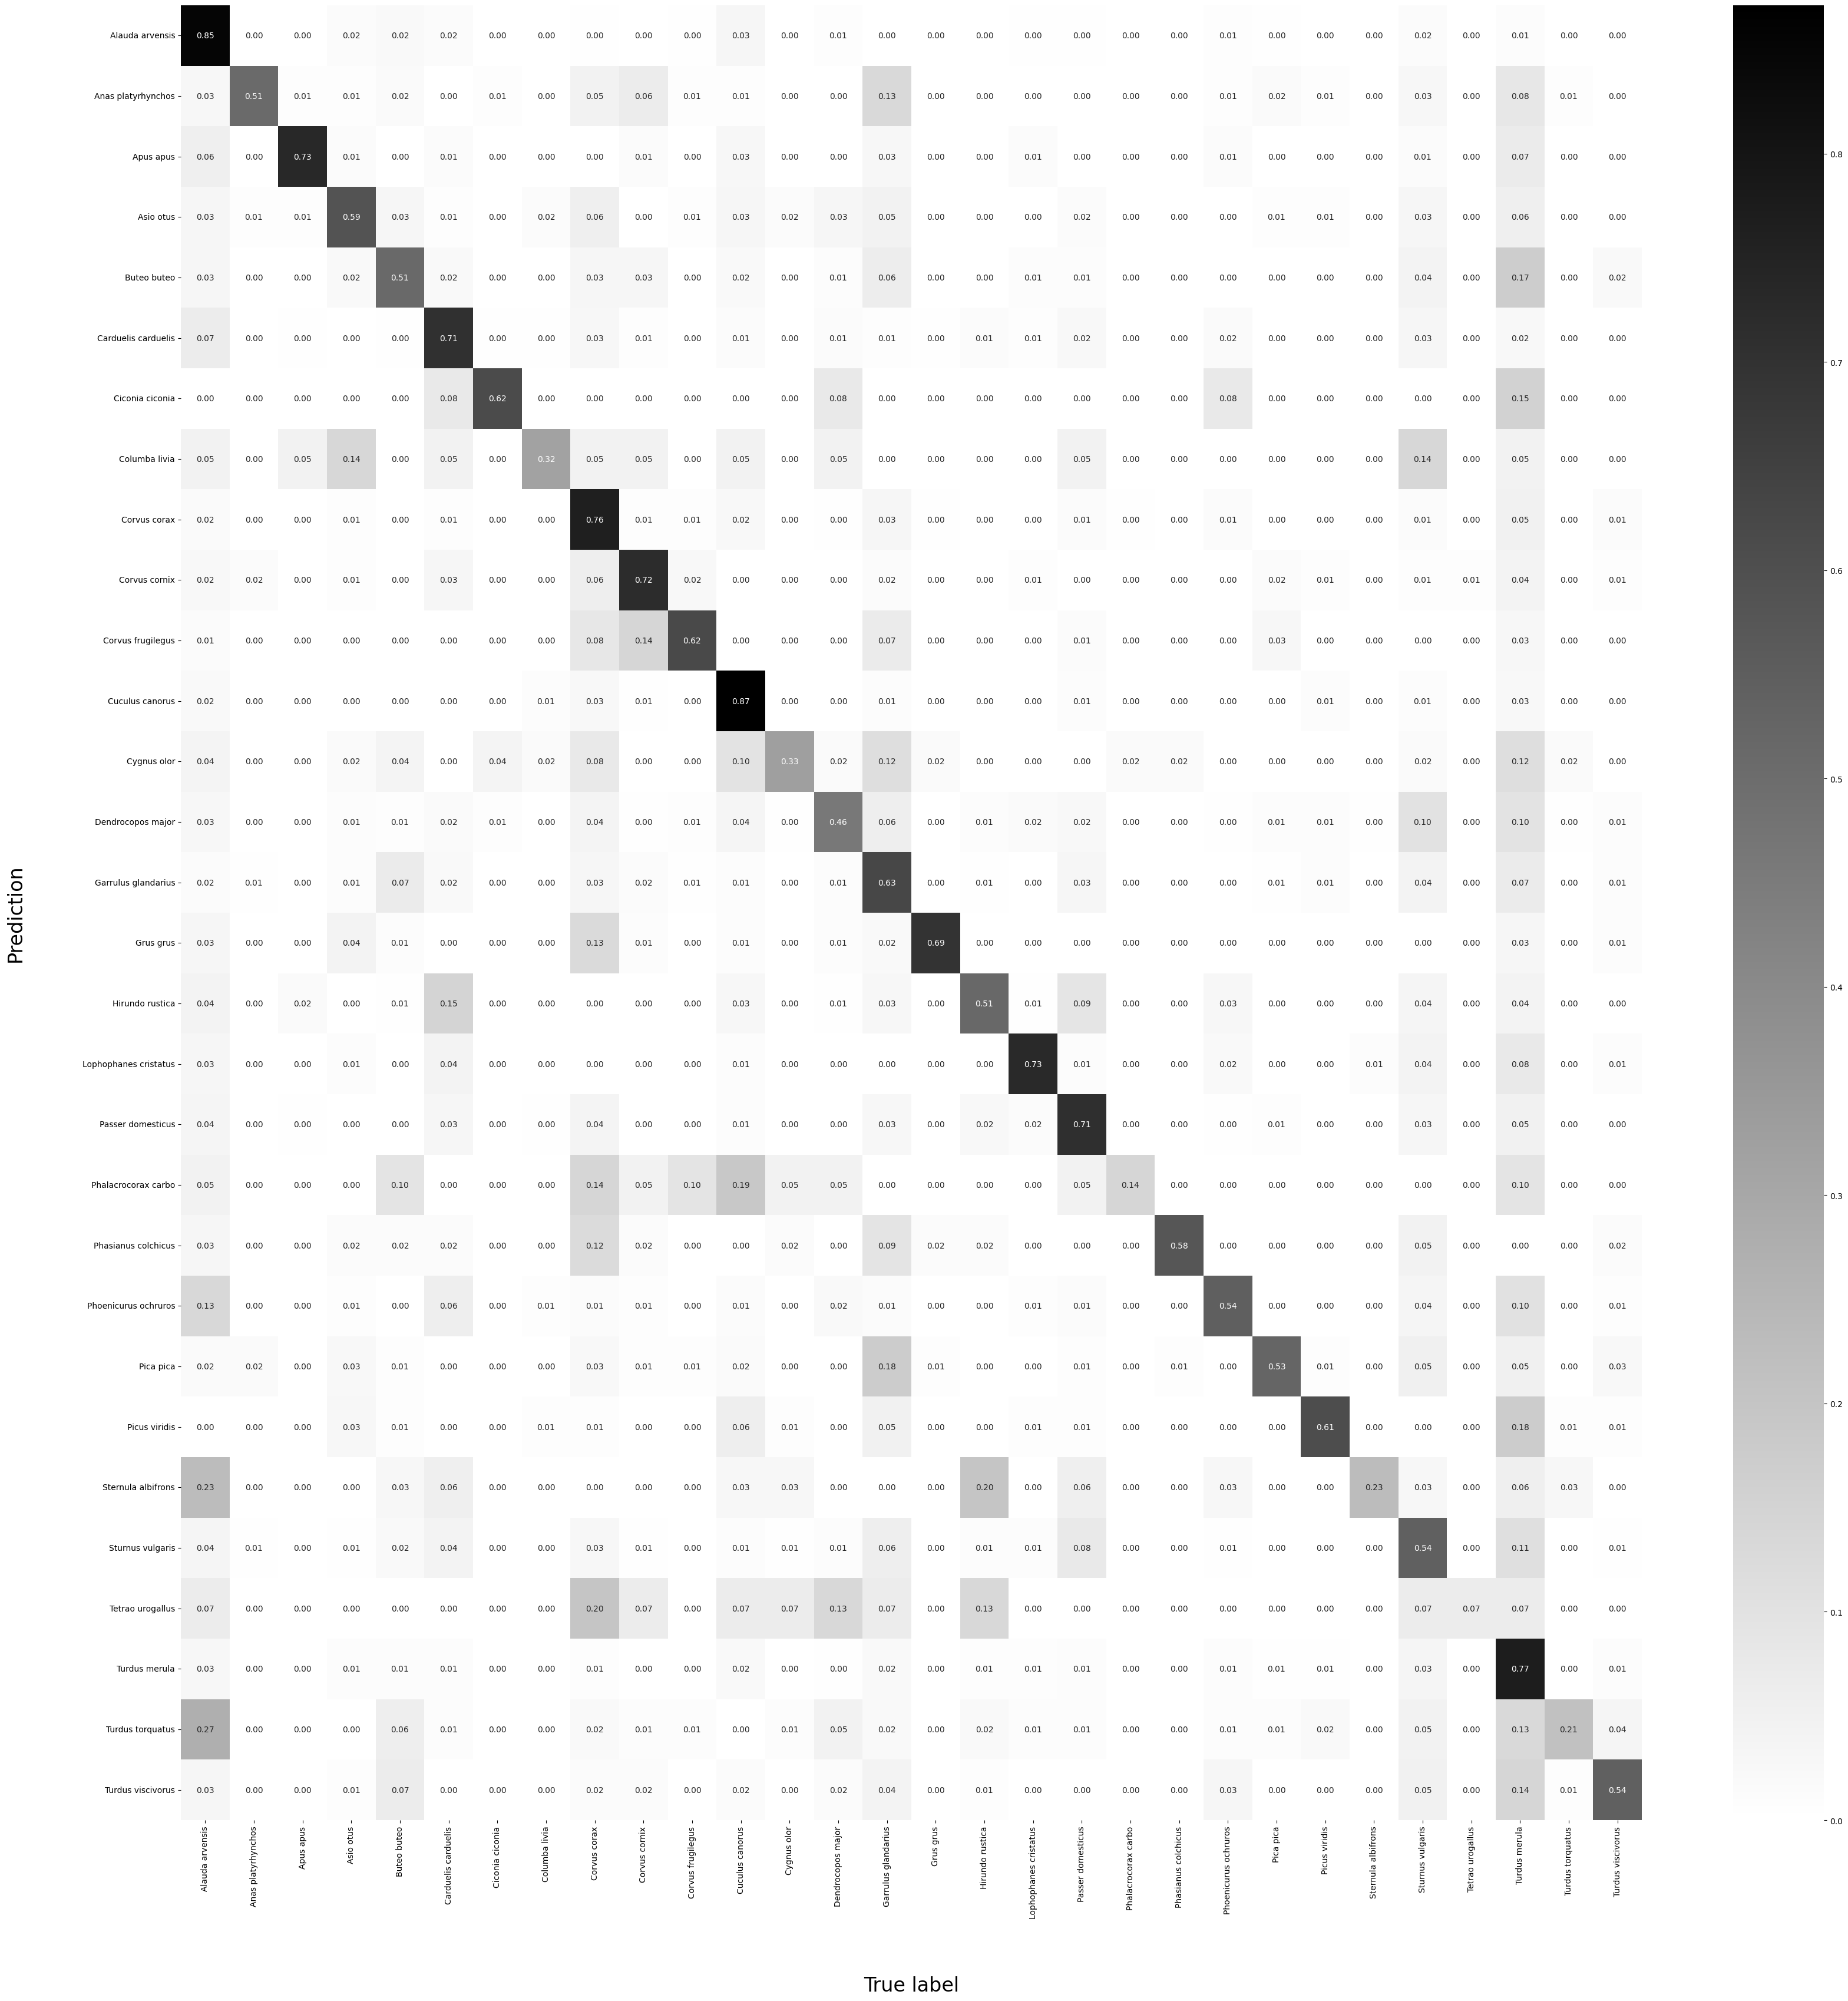

In [26]:
cm = c_matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm)
df_cm.columns = train_ds.get_mapping().values()
df_cm.index = train_ds.get_mapping().values()
plt.figure(figsize = (40,40))
s = sns.heatmap(df_cm, annot=True, cmap = 'binary', fmt='.2f')
s.set_xlabel('Prediction', fontsize=24, labelpad=70)
s.set_ylabel('True label', fontsize=24, labelpad=70)
# s.set_title("Confusion matrix of predictions")

## Most common mistakes

In [27]:
import numpy as np


map = train_ds.get_mapping()
def top_n_argmax_2d(array_2d, N):
    np.fill_diagonal(array_2d, 0)
    flat_indices = np.argpartition(array_2d.flatten(), -N)[-N:]
    indices_2d = np.unravel_index(flat_indices, array_2d.shape)
    return list(zip(indices_2d[0], indices_2d[1]))

N = 25 
top_indices = top_n_argmax_2d(cm, N)

# Print the indices of the top N elements
df = pd.DataFrame(columns=["Predicted", "True Label", "Frequency"])
for i, index in enumerate(top_indices):
    df.loc[len(df)] = [map[index[0]], map[index[1]], cm[index]]
df.sort_values(by = "Frequency", ascending=False)

,Predicted,True Label,Frequency
12,Turdus torquatus,Alauda arvensis,0.273810
18,Sternula albifrons,Alauda arvensis,0.228571
10,Tetrao urogallus,Corvus corax,0.200000
15,Sternula albifrons,Hirundo rustica,0.200000
17,Phalacrocorax carbo,Cuculus canorus,0.190476
19,Picus viridis,Turdus merula,0.176471
23,Pica pica,Garrulus glandarius,0.175439
20,Buteo buteo,Turdus merula,0.170213
13,Ciconia ciconia,Turdus merula,0.153846
8,Hirundo rustica,Carduelis carduelis,0.149701


## Training

In [28]:
import seaborn as sns
train_loss_df = pd.read_csv('saved_models/cnn_20231121_011424.csv')
ax = sns.lineplot(data=train_loss_df, x="Step", y="Value")
ax.set(xlabel='Step (batch size = 32)', ylabel='Loss', title = 'Train loss')

FileNotFoundError: [Errno 2] No such file or directory: 'saved_models/cnn_20231121_011424.csv'

In [ ]:
maf1 = pd.read_csv('saved_models/cnn_20231121_011424_Macro_averaged_f1_score_Validation.csv')
ax = sns.lineplot(data=maf1, x="Step", y="Value")
ax.set(xlabel='Epoch', ylabel='Score', title = "F1-score (macro)")

In [ ]:
loss_training_df = pd.read_csv('saved_models/cnn_20231121_011424_Training vs. Validation Loss_Training.csv')
loss_validation_df = pd.read_csv('saved_models/cnn_20231121_011424_Training vs. Validation Loss_Validation.csv')
loss_training_df['split'] = 'train loss'
loss_validation_df['split'] = 'validation loss'
loss_training_df = loss_training_df[['Step', 'Value', 'split']]
loss_validation_df = loss_validation_df[['Step', 'Value', 'split']]
combined_df = pd.concat([loss_training_df, loss_validation_df])
ax = sns.lineplot(x="Step", y="Value", hue="split", ci="sd", data=combined_df)
ax.set(xlabel='Epoch', ylabel='Loss', title = "Loss")
